# Proof of Concept: El Niño 1997/1998
This Jupyter Notebook reproduces the results of a study investigating causal relationships among climate variables during the 1997/1998 El Niño event using the PCMCI+ causal discovery algorithm. 

**Table of candidate variables:**

| Variables (nodes)     | Dataset        | Definition                                   | Region                           |
|------------------------|-----------------|----------------------------------------------|----------------------------------|
| SST Niño3.4            | HadISST         | SSTAs over the Niño3.4 region (°C)           | 5°S-5°N, 170°W-120°W             |
| Uwind CPAC             | NCEP-NCAR-R1    | Westerly Wind Anomalies in Central Pacific (m.s$^{-1}$) | 5°S-5°N, 180°W-150°W   |
| Wind$_{Stress}$ WPAC   | ORAS5           | West Pacific Wind Stress Anomalies (N.m$^{-2}$) | 5°S-5°N, 140°E-170°E           |
| SLP$_{grad}$ EPAC-WPAC | NCEP-NCAR-R1    | East-West Sea Level Pressure Anomaly Gradient (Pa) | [5°S-5°N, 100°E-160°E] minus [5°S-5°N, 100°W-160°W] |
| Tcline$_{Depth}$ EPAC  | ORAS5           | Depth of 20°C Isotherm in the Eastern Pacific (m) | 5°S-5°N, 150°W-120°W           |

 The time series (**Fig. 2a**) and causal network (**Fig. 2b**), in addition to the uncertainties for coefficients (Supplementary **Fig. S3**) are reproduced in this notebook.
 

 PS: Wind$_{Stress}$ and Tcline$_{Depth}$ require regridding of ORAS5 data. This has been done using cdo:

```cdo -remapbil,r360x180 sozotaux_control_monthly_highres_2D_199501_199912.nc sozotaux_control_monthly_highres_2D_199501_199912_360x180.nc``` ( for Wind$_{Stress}$ )
    
```cdo -remapbil,r360x180 so20chgt_control_monthly_highres_2D_199501_199912_CONS_v0.1.nc outfile_so20c.nc``` ( for Tcline$_{Depth}$ )

# Imports

In [11]:
import warnings
warnings.filterwarnings("ignore") # Ignore warnings while loading 
import numpy as np
from matplotlib import pyplot as plt
from utils import Utils as utils
from glob import glob
from tigramite import plotting as tp
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.robust_parcorr import RobustParCorr  # , GPDC, CMIknn, CMIsymb
from tigramite.pcmci import PCMCI
from tigramite import data_processing as pp
import xarray as xr
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load data sets, calculate candidate variables

#### **! Adjust path to data and file names accordingly !**

In [2]:
# Sample dataset for reference grid (lat: 180, lon: 360)
# We choose the PSL MEM dataset as the reference grid for the interpolation
path_to_psl_em = "/work/bd1083/b380749/esmval/recipe_EM_psl_20230323_234348/preproc/dummy_diagnostic_1/psl/"
path_to_ncar = "/work/bd0854/DATA/ESMValTool2/OBS/Tier2/NCEP-NCAR-R1/" # for ua and psl
path_to_hadisst = "/work/bd1083/b380749/b380749/NetCDF/raw_netcdf_cmip6/obs/" # for ts
path_to_netcdf = "/work/bd1083/b380749/b380749/NetCDF/"    # for iso20c and WindStress

ds_psl_em = xr.open_dataset(
    path_to_psl_em
    + "CMIP6_MultiModelMean_historical_EnsembleMean_Amon_psl_1900-2014.nc"
).sel(time=slice('1995-01-01', '1999-12-01'))

# Datasets
ds_ua_obs = xr.open_dataset(path_to_ncar+
    'OBS6_NCEP-NCAR-R1_reanaly_1_Amon_ua_194801-202210.nc'
).sel(time=slice('1995-01-01', '1999-12-01')).sel(plev=92500)

ds_psl_obs = xr.open_dataset(path_to_ncar+
    'OBS6_NCEP-NCAR-R1_reanaly_1_Amon_psl_194801-202210.nc'
).sel(time=slice('1995-01-01', '1999-12-01'))

ds_ts_obs = xr.open_dataset(path_to_hadisst+
    "OBS_HadISST_reanaly_1_Amon_ts_187001-201712.nc"
).sel(time=slice("1995-01-16", "1999-12-16"))

ds_iso20c_obs = xr.open_dataset(path_to_netcdf+
    'outfile_so20c.nc'
)

ds_WindStress_obs = xr.open_dataset(path_to_netcdf+
    'sozotaux_control_monthly_highres_2D_199501_199912_360x180.nc'
)

# Rename dimensions for consistency
ds_iso20c_obs = ds_iso20c_obs.rename({'time_counter': 'time'})
ds_WindStress_obs = ds_WindStress_obs.rename({'time_counter': 'time'})

# Interpolate datasets to the reference grid
ds_ts_obs = ds_ts_obs.interp(lon=ds_psl_em['lon'], lat=ds_psl_em['lat'])
ds_psl_obs = ds_psl_obs.interp(lon=ds_psl_em['lon'], lat=ds_psl_em['lat'])
ds_ua_obs = ds_ua_obs.interp(lon=ds_psl_em['lon'], lat=ds_psl_em['lat'])
ds_iso20c_obs = ds_iso20c_obs.interp(lon=ds_psl_em['lon'], lat=ds_psl_em['lat'])
ds_WindStress_obs = ds_WindStress_obs.interp(lon=ds_psl_em['lon'], lat=ds_psl_em['lat'])

# Extract time series for various variables
nino34_3D, nino34 = utils.extract_reg_timeseries1(ds_ts_obs['ts'], -5, 5, 190, 240)
depthermo = ds_iso20c_obs['so20chgt'].sel(lat=slice(-5, 5), lon=slice(210, 260)).mean(dim=['lat', 'lon'])
Uwinda_180210_3D, Uwinda_180210 = utils.extract_reg_timeseries1(ds_ua_obs['ua'], -5, 5, 180, 210, seasonal=False)
PSLa_epac_minus_cpac = utils.calculate_slp_grad(ds_psl_obs['psl'], None, seasonal=False)
Ustress_140170_3D, Ustress_140170 = utils.extract_reg_timeseries1(ds_WindStress_obs['sozotaux'], -5, 5, 140, 170)


# Set up dataframe and plot time series


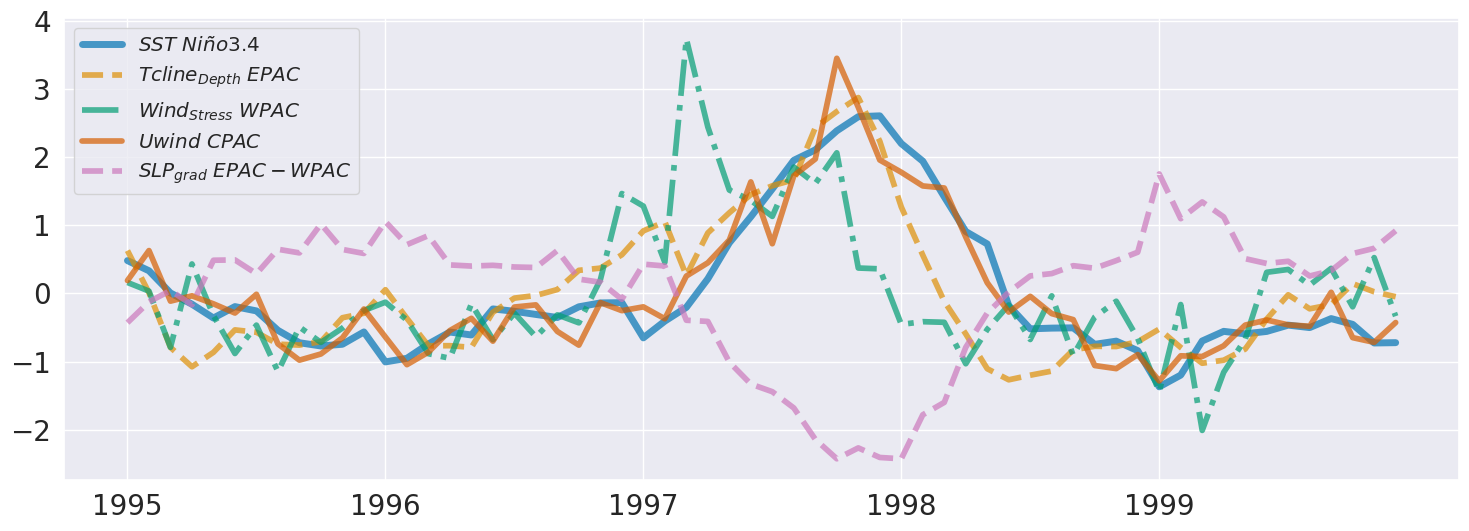

In [9]:
# Parameters
detrend = True
stddz = True
min_tau, max_tau = 0, 3
pc_alpha = 0.1

# Variable names for plotting
var_names = ['$SST$\n$Niño3.4$', '$Tcline_{Depth}$\n$EPAC$', '$Wind_{Stress}$\n$WPAC$',
             '$Uwind$\n$CPAC$', '$SLP_{grad}$\n$EPAC-WPAC$']

# Data extraction and preparation
data = np.zeros((len(nino34.values), len(var_names)))
data[:, 1] = depthermo.values
data[:, 0] = nino34.values
data[:, 2] = Ustress_140170.values
data[:, 3] = Uwinda_180210.values
data[:, 4] = PSLa_epac_minus_cpac.values


# Data processing (detrend and standardize)
T, N = data.shape

if detrend:
    for i in range(N):
        data[:, i] = utils.detrend_kw(data[:, i])
if stddz:
    for var in range(N):
        data[:, var] = data[:, var] / np.std(data[:, var])

# years for x-axis
yearsarrobs=Uwinda_180210['time.year'].values[:]

# Set Seaborn style
sns.set(style="darkgrid")

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(18, 6))

# Define line styles and colors
line_styles = ['-', '--', '-.']  # Different line styles
colors = sns.color_palette("colorblind", n_colors=20)[::]

# Loop over the variables for plotting
for i in range(N):
    x1 = range(len(data[:, i]))

    # Adjust line width based on the variable index
    linwid = 5 if i == 0 else 4.1

    # Plot data using Seaborn's lineplot
    sns.lineplot(
        x=x1,
        y=data[:, i],
        color=colors[i],
        linestyle=line_styles[i % len(line_styles)],
        linewidth=linwid,
        alpha=0.7,
        label=var_names[i].replace('\n', ' ')
    )

# Set x-axis ticks and labels
ax.set_xticks(x1[::12])
ax.set_xticklabels(yearsarrobs[::12], size=30)

# Set tick parameters
ax.tick_params(axis='both', which='major', labelsize=20)

# Display legend and show plot
plt.legend(fontsize='large')
plt.show()
plt.close()


# Run PCMCI+

The study focuses on estimating dependencies for lags between 0 and 3 months ($\tau_{min}$ = 0, $\tau_{max}$ = 3) with a significance threshold $\alpha_{pc}$ set to 0.1.

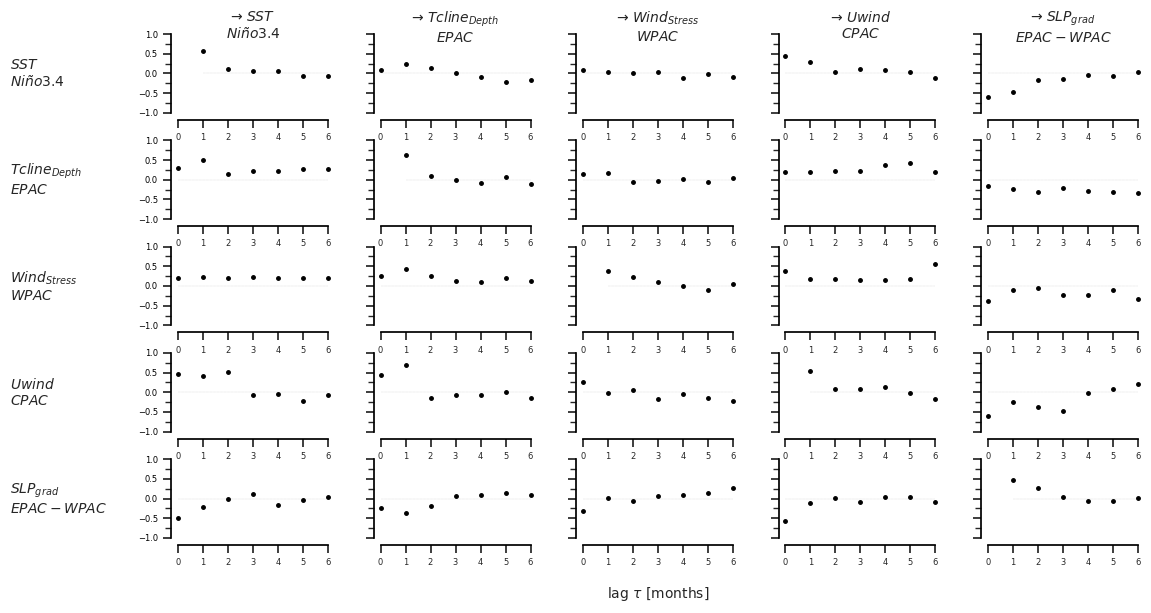

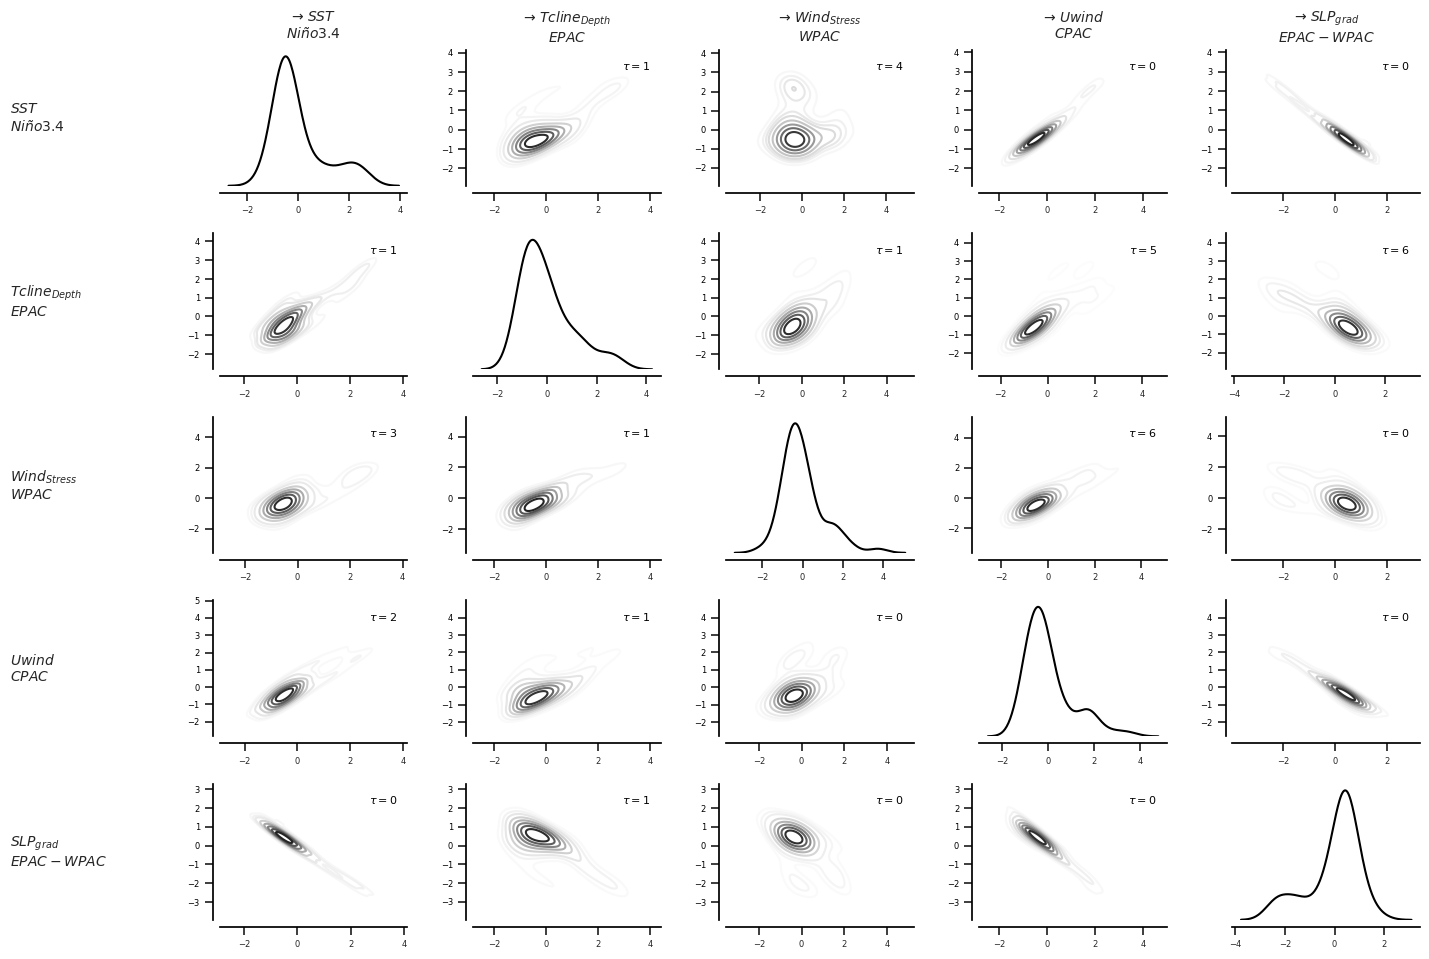

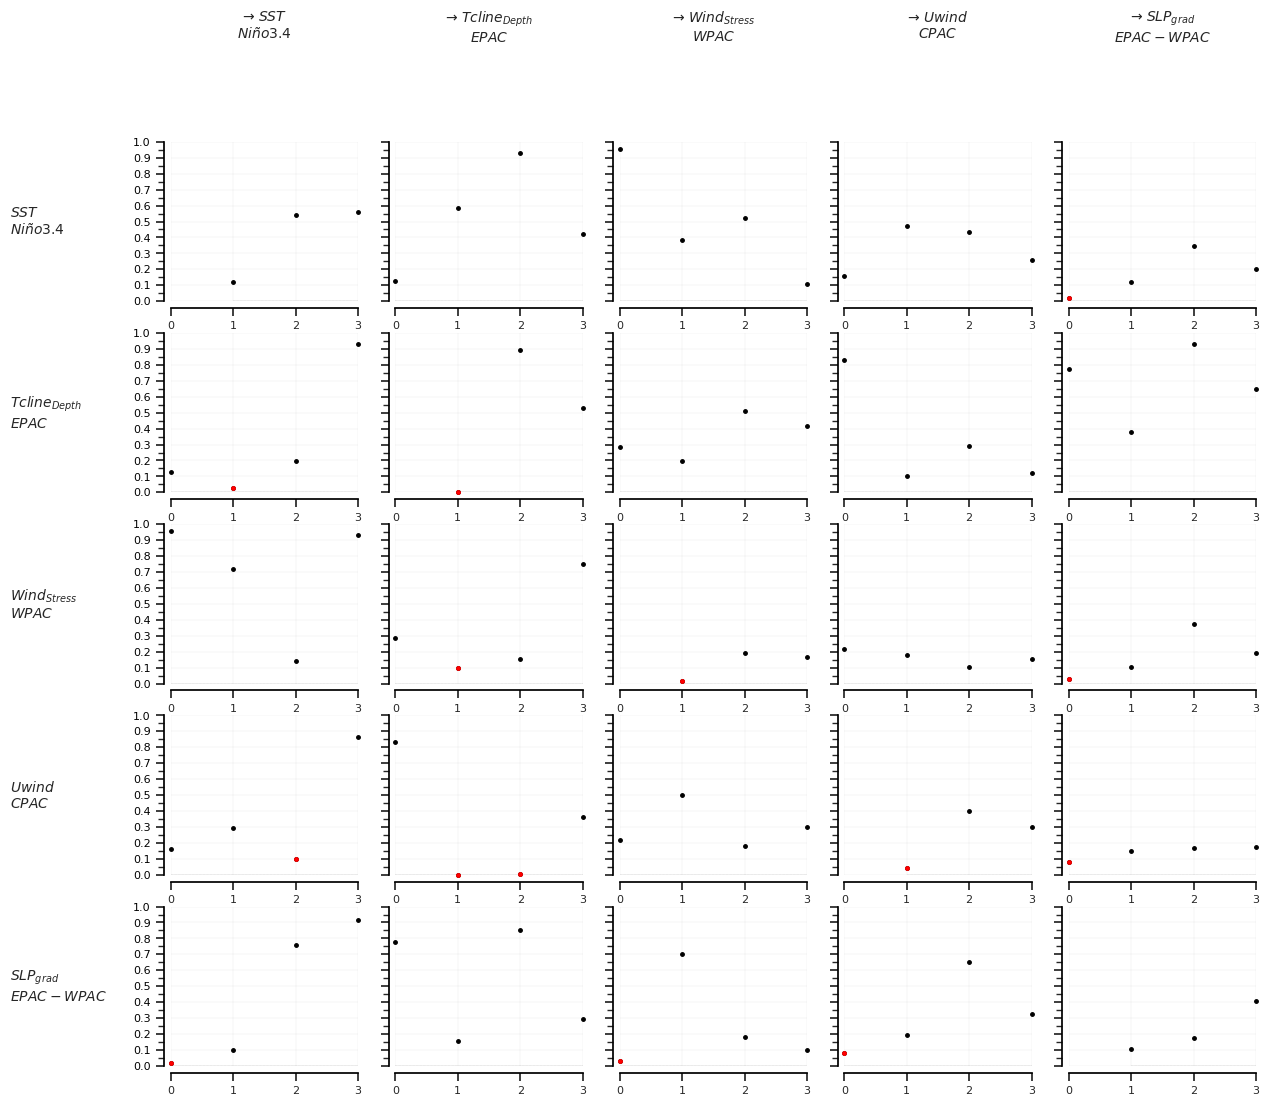

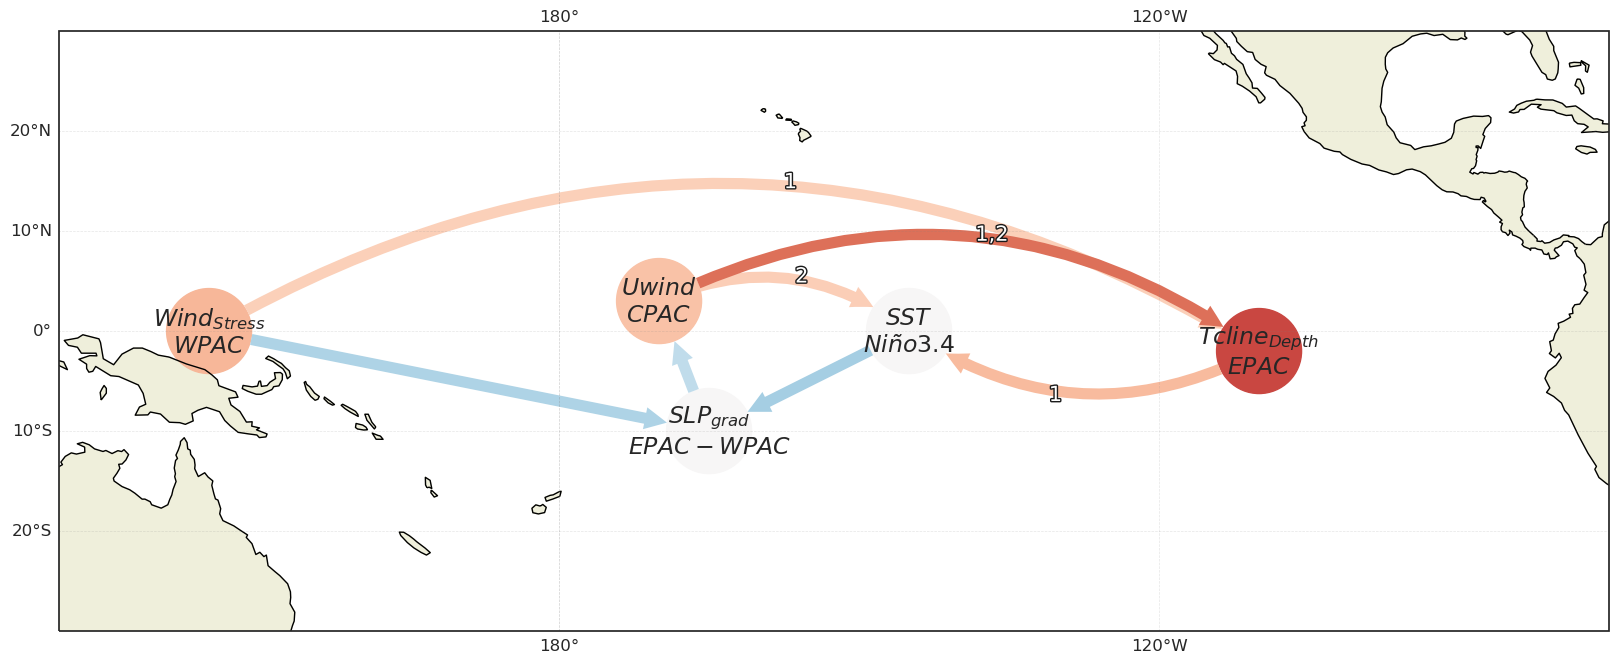

In [10]:

x = np.array([35, 70, -35, 10, 15])  # degree to the east
y = np.array([0, -2, 0, 3, -10])    # degree to the south (negative)
node_pos = {'x': x, 'y': y, 'transform': ccrs.PlateCarree(central_longitude=180)}  # coordinate reference system

# PCMCI Initialization
dataframe = pp.DataFrame(data, var_names=var_names, mask=None)
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=RobustParCorr(), verbosity=0)

# Run PCMCI for bivariate conditional independence test
correlations = pcmci.run_bivci(tau_min=min_tau, tau_max=6, val_only=True)['val_matrix']

# Plot lag functions
setup_args = {'var_names': var_names, 'figsize': (12, 6), 'x_base': 1, 'lag_units': 'months', 'y_base': .5,
              'label_space_left': .15}
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, name=None, setup_args=setup_args)

# Plot density plots
matrix_lags = np.argmax(np.abs(correlations), axis=2)
tp.plot_densityplots(dataframe=dataframe, setup_args={'figsize': (15, 10)},
                     add_densityplot_args={'matrix_lags': matrix_lags})
plt.show()

# Run PCMCIplus for causal discovery
results_masking = pcmci.run_pcmciplus(tau_min=min_tau, tau_max=max_tau, pc_alpha=pc_alpha)

# Plot lag functions with significance
lag_p_matrix = tp.setup_matrix(N=N, tau_max=max_tau, minimum=0., maximum=1, figsize=(14, 12), x_base=1, y_base=.1,
                               tick_label_size=8, legend_width=1, lag_units='seasons',
                               plot_gridlines=True, var_names=var_names, legend_fontsize=15, label_space_left=.2)
lag_p_matrix.add_lagfuncs(val_matrix=results_masking['p_matrix'], color='black')
lag_p_matrix.add_lagfuncs(val_matrix=(np.where(results_masking['p_matrix'] <= pc_alpha, results_masking['p_matrix'], None)),
                          color='red')

# Plot the graph
fig, ax = plt.subplots(figsize=(20, 20), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180.)))
ax.set_extent([-50, 105, -30, 30], crs=ccrs.PlateCarree(central_longitude=180.))
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.2, linestyle='--')
tp.plot_graph(fig_ax=(fig, ax), graph=results_masking['graph'], val_matrix=results_masking['val_matrix'],
              var_names=var_names, vmin_edges=-1, vmax_edges=1, vmin_nodes=-1, vmax_nodes=1, node_pos=node_pos,
              cmap_nodes="RdBu_r", node_size=8.5, arrowhead_size=12, curved_radius=0.3, node_label_size=17,
              link_label_fontsize=15, node_colorbar_label='auto-MCI', link_colorbar_label='cross-MCI',
              save_name=None, show_colorbar=False)
plt.show()